# Workshop Notebook 2: Text Classification on True Voice Intent Dataset with PyThaiNLP



Updated: 31 October 2019


----

True Voice Intent Dataset : https://github.com/PyThaiNLP/truevoice-intent

Intent Dataset from Customer Service Phone Calls Transcribed by TrueVoice's Mari.


#### Required packages


Visualization
  - `matplotlib`
  - `seaborn`
  
Machine Learning
  - `sklearn`
  
Dataframe, Data structure
  - `pandas`
  - `numpy`

In [1]:
!pip install -q emoji

In [ ]:
!pip install --upgrade --user -q --pre pythainlp

In [ ]:
!pip install --user -q matplotlib==3.1.0 numpy pandas sklearn seaborn

In [2]:
import os
import re
from functools import partial

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import Normalizer

from sklearn.svm import LinearSVC
from pythainlp.tokenize import word_tokenize
from pythainlp.ulmfit import ungroup_emoji

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Explore the dataset



### 1.1 Load dataset

In [3]:
TRUEVOICE_INTENT_DIR = "../data/truevoice_intent"

truevoice_dataset_path = { 
    "train": os.path.join(TRUEVOICE_INTENT_DIR, "mari_train.csv"),
    "test": os.path.join(TRUEVOICE_INTENT_DIR, "mari_test.csv")
}
truevoice_dataset_path


{'train': '../data/truevoice_intent/mari_train.csv',
 'test': '../data/truevoice_intent/mari_test.csv'}

In [4]:
truevoice_dataset = {
    "train": pd.read_csv(truevoice_dataset_path["train"]),
    "test": pd.read_csv(truevoice_dataset_path["test"])
}

### 1.2  Customer voice transcription and Destination

In [5]:
truevoice_dataset["train"].head(10)

,texts,texts_deepcut,action,object,destination
0,ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต . บ...,ผม ไป จ่าย เงิน ที่ Counter Services เค้า เช็...,enquire,payment,billing and payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,internet ยัง ความ เร็ว อยุ่ เท่า ไหร ครับ,enquire,package,promotions
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,ตะกี้ ไป ชำระ ค่า บริการ ไป แล้ว แต่ ยัง ใช้ ...,report,suspend,billing and payment
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,พี่ ค่ะ ยัง ใช้ internet ไม่ ได้ เลย ค่ะ เป็น...,enquire,internet,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,ฮาโหล คะ พอดี ว่า เมื่อ วาน เปิด ซิม ทรูมูฟ แ...,report,phone_issues,billing and payment
5,* ใช้งานยังไง ขอรายละเอียดการสมัครหน่อย,* ใช้ งาน ยัง ไง ขอ รายละเอียด การ สมัคร หน่อย,enquire,service,other queries
6,เคยมีช่างมาซ่อมที่บ้าน แล้วโทรศัพท์ใช้งานไม่ไ...,เคย มี ช่าง มา ซ่อม ที่ บ้าน แล้ว โทรศัพท์ ใช...,enquire,nontruemove,other queries
7,ค้างค่าบริการเท่าไหร่ครับ,ค้าง ค่า บริการ เท่า ไหร่ ครับ,enquire,balance,billing and payment
8,อินเตอร์เน็ตไฟ Adsl ไม่มีสัญญาณครับ,อินเตอร์เน็ต ไฟ Adsl ไม่ มี สัญญาณ ครับ,enquire,nontruemove,other queries
9,เค้าบอกจะส่งรหัสเน็ตมาให้ แต่ยังไม่ได้ส่งมาเล...,เค้า บอก จะ ส่ง รหัส เน็ต มา ให้ แต่ ยัง ไม่ ...,enquire,internet,internet


### 1.2 Data Statistics

#### Number of examples for the training and test set

In [6]:
truevoice_dataset["train"].describe()

,texts,texts_deepcut,action,object,destination
count,12939,12939,12939,12939,12939
unique,11398,11363,8,26,7
top,สอบถามยอดค้างชำระค่ะ,สอบถาม ยอดค้าง ชำระ ค่ะ,enquire,service,billing and payment
freq,10,10,8133,2090,5007


In [7]:
truevoice_dataset["test"].describe()

,texts,texts_deepcut,action,object,destination
count,3236,3236,3236,3236,3236
unique,2003,2003,8,24,7
top,บริการอื่นๆ,บริการ อื่น ๆ,enquire,internet,billing and payment
freq,97,97,2351,524,977


#### Percentage of class labels

In [8]:
for set_name in ["train", "test"]:
    print("set:", set_name)
    print("")
    print(truevoice_dataset[set_name]['destination'].value_counts() / truevoice_dataset[set_name].shape[0] * 100)
    print("\n\n")

set: train

billing and payment      38.696963
promotions               24.259989
other queries            17.288817
internet                 14.390602
international dialing     2.596800
true money                1.553443
lost and stolen           1.213386
Name: destination, dtype: float64



set: test

billing and payment      30.191595
internet                 19.004944
promotions               18.232386
other queries            16.965389
international dialing     6.273177
lost and stolen           6.056860
true money                3.275649
Name: destination, dtype: float64





## 2. Data Preprocessing

In this tutorial, we will use `CountVectorizer` from scikit-learn [link](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

- `CountVectorizer` converts a collection of text documents to a matrix of token counts

```python
documents = ["ฉันขึ้นรถไฟ", "ฉันชอบรถไฟฟ้า", "ฉันชอบรถไฟ รถไฟ"]

vocabulary = Set['ขึ้น', 'ฉัน', 'ชอบ', 'รถไฟ', 'รถไฟฟ้า']
```


In [9]:
documents = ["ฉันขึ้นรถไฟ", "ฉันชอบรถไฟฟ้า", "ฉันชอบรถไฟ รถไฟ"]

In [10]:
vectoizer = CountVectorizer(tokenizer=word_tokenize)
X = vectoizer.fit_transform(documents)

In [11]:
vectoizer.get_feature_names()

[' ', 'ขึ้น', 'ฉัน', 'ชอบ', 'รถไฟ', 'รถไฟฟ้า']

In [12]:
X.toarray()

array([[0, 1, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 1],
       [1, 0, 1, 1, 2, 0]])

In [13]:
print(vectoizer.get_feature_names(), "\n")
for i, document in enumerate(documents):
    tokens = word_tokenize(document)
    print(document,"\n", tokens,"\n", X.toarray()[i])
    print("")
                             


[' ', 'ขึ้น', 'ฉัน', 'ชอบ', 'รถไฟ', 'รถไฟฟ้า'] 

ฉันขึ้นรถไฟ 
 ['ฉัน', 'ขึ้น', 'รถไฟ'] 
 [0 1 1 0 1 0]

ฉันชอบรถไฟฟ้า 
 ['ฉัน', 'ชอบ', 'รถไฟฟ้า'] 
 [0 0 1 1 0 1]

ฉันชอบรถไฟ รถไฟ 
 ['ฉัน', 'ชอบ', 'รถไฟ', ' ', 'รถไฟ'] 
 [1 0 1 1 2 0]



#### Define a function to process texts

In [14]:
def process_text(text):
    text = text.lower()
    words = word_tokenize(text, keep_whitespace=False)    
    return words

In [15]:
process_text("Hello ฉัน")

['hello', 'ฉัน']

## 3. Model Training

#### 3.1 Define preprocessing/training pipeline

1. Vectorize text with `CountVectorizer`.
2. Normalize Count Vector with L2 norm.
3. Fit the training data with __Linear Support Vector Classification__ ([LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)).


![title](images/svc.png)

Image from: https://scikit-learn.org/stable/modules/svm.html#svm-classification

In [16]:
classifier = Pipeline([
    ('count_vectorizer', CountVectorizer(tokenizer=process_text,
                                         ngram_range=(1,2))),
    ('normalizer', Normalizer()),
    ('classifier', LinearSVC(max_iter=25000, random_state=1, class_weight="balanced")),
])


In [17]:
X_train, y_train = truevoice_dataset["train"]['texts'], truevoice_dataset["train"]["destination"]
X_test, y_test = truevoice_dataset["test"]['texts'], truevoice_dataset["test"]["destination"]

#### 3.2 Fit traing data.

In [18]:
classifier.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('count_vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function process_text at 0x1a1f2cf200>,
                                 vocabulary=None)),
                ('normalizer', Normalizer(copy=True, norm='l2')),
                ('classifier',
                 LinearSVC(C=1.0, class_weight='balanced', dual=True,
                           fit_intercept=True, intercept_scaling=1,
                    

#### 3.3 Make prediction from testing data

In [19]:
predictions = classifier.predict(X_test)

### Example predictions

In [20]:
for index, x in enumerate(X_test[10:25]):
    print("question: {}".format(x))
    print("groundtruth: {}".format(y_test[index]))
    print("predition: {}".format(predictions[index]))
    print("")

question: อยากทราบว่าใช้นาที ไปเท่าไหร่แล้วคะ แล้วถ้าเปิด ไวไฟ ทิ้งไว้ และ ไวไฟ แชร์กับอีกเครื่องนึง ไวไฟ จะเสียค่าบริการเพิ่มไหมคะ
groundtruth: promotions
predition: promotions

question: อยากทราบว่าในรอบบิลใหม่จะเริ่มใช้ 3G ได้อีกตั้งแต่วันที่เท่าไหร่
groundtruth: other queries
predition: other queries

question: อยากทราบว่าในรอบบิลใหม่จะเริ่มใช้ 3G ได้อีกตั้งแต่วันที่เท่าไหร่
groundtruth: promotions
predition: promotions

question: อยากทราบว่าในรอบบิลใหม่จะเริ่มใช้ สามจี ได้อีกตั้งแต่วันที่เท่าไหร่
groundtruth: billing and payment
predition: billing and payment

question: อยากทราบว่าไพศาล พันธุ์จูเดือนนี้ต้องจ่ายค่าเน็ตเท่าไหร่อะคะ
groundtruth: promotions
predition: promotions

question: อยากทราบว่าข้อความที่เข้าในมือถืออ่ะครับ ไม่ทราบว่าเป็นรายการอ่ะไรน่ะครับ อยากยกเลิกน่ะครับ
groundtruth: billing and payment
predition: promotions

question: อยากทราบว่าของเดือนมกราหน่ะ หมายเลข 0841467112 ของเดือนที่แล้วนี่ ต้องชำระให้เท่าไหร่
groundtruth: promotions
predition: promotions

question:

#### __Question 1:__ How many examples in test set `y_test` that are predicted incorrectly.


Hint:
```python
>>> print(predictions.shape, y_test.shape)
(3236,) (3236,)

>>> print(predictions[0])
promotions

>>> print(y_test[0])
promotions
```

In [21]:
## Write down the code to find the answer








##

__Solution__:

In [22]:
indices = X_test[predictions != y_test].index
print("Number of examples that predicted incorrectly = {}".format(len(indices)))

Number of examples that predicted incorrectly = 337


In [23]:
for index in indices[:15]:
    print(index, X_test.iloc[index])
    print(" groundtruth:", y_test.iloc[index])
    print(" prediction:", predictions[index])
    print("")

5 อยากทราบว่าโปรโมชั่นที่พี่ได้รับเนี่ย โทรยกก๊วน3คนสนิท นาทีละ 25 บาท แล้วต้องทำยังไงเค้าถึงจะรู้ว่าเบอร์3คนสนิทคือใครคะ
 groundtruth: billing and payment
 prediction: promotions

8 อยากทราบว่าโปรนี้เล่นเน็ตไม่ได้แล้วคือโปรหมดรึป่าว
 groundtruth: internet
 prediction: promotions

10 อยากทราบว่าใช้นาที ไปเท่าไหร่แล้วคะ แล้วถ้าเปิด ไวไฟ ทิ้งไว้ และ ไวไฟ แชร์กับอีกเครื่องนึง ไวไฟ จะเสียค่าบริการเพิ่มไหมคะ
 groundtruth: billing and payment
 prediction: internet

19 อยากทราบว่าค่าโทรไป America oทีละเท่าไรค่ะ
 groundtruth: international dialing
 prediction: billing and payment

24 อยากทราบว่าช่อง 24 มันหายไปไหนแล้วค่ะ
 groundtruth: other queries
 prediction: billing and payment

26 อยากทราบว่าซิมโดนล๊อค PUK
 groundtruth: internet
 prediction: billing and payment

29 อยากทราบว่าซื้อซิมใหม่ ยังไม่มีหมายเลขให้เรา เราจะทราบหมายเลขได้ยังไง
 groundtruth: billing and payment
 prediction: other queries

41 อยากทราบว่าตั้งโอนสายไปอีกหมายเลขนึงได้หมายครับ
 groundtruth: other queries
 prediction: inte

## 4. Model Evaluation

In [24]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore')

#### 4.1 Metrics

__Per-class Accuracy__

$$
\text{class_accuracy}(i) = \frac{\text{Number of correct prediction for class } i}{\text{Number of samples are in class } i}
$$


__Per-class F1__

$$
\text{class_f1}(i) = \frac{ 2 \cdot (\text{class_precision}(i) \cdot \text{class_recall}(i)) }{ \text{class_precision}(i) + \text{class_recall}(i) }
$$


__Per-class Precision__

$$
\text{class_precision}(i) =  \frac{\text{Number of correct prediction for class } i}{\text{Number of correct prediction for class } i + \text{Number of samples in other classes predicted as class } i \text{ (False Positive)}}
$$

__Per-class Recall__

$$
\text{class_recall}(i) =  \frac{\text{Number of correct prediction for class } i}{\text{Number of correct prediction for class } i + \text{Number of samples in class } i  \text{ that predicted as other classes (False Negative)}}
$$

----

Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [25]:
onehot_encoder_fit = onehot_encoder.fit(truevoice_dataset["test"]["destination"][:,None])
predictions_onehot = onehot_encoder_fit.transform(predictions[:,None]).toarray()

y_onehot = onehot_encoder_fit.transform(truevoice_dataset["test"]["destination"][:,None]).toarray()
    
nb_class = 7
for i in range(nb_class):
    print("Class: ", i, )
    print("Accuracy: {:.2f} ".format((predictions_onehot[:,i] == y_onehot[:,i]).mean()))
    print("F1-score: {:.2f} ".format(f1_score(predictions_onehot[:,i], y_onehot[:,i])))
    print("Precision: {:.2f} ".format(precision_score(predictions_onehot[:,i],y_onehot[:,i])))
    print("Recall: {:.2f} ".format(recall_score(predictions_onehot[:,i], y_onehot[:,i])))
    print("")

Class:  0
Accuracy: 0.95 
F1-score: 0.91 
Precision: 0.89 
Recall: 0.94 

Class:  1
Accuracy: 0.99 
F1-score: 0.93 
Precision: 0.94 
Recall: 0.91 

Class:  2
Accuracy: 0.95 
F1-score: 0.87 
Precision: 0.93 
Recall: 0.82 

Class:  3
Accuracy: 1.00 
F1-score: 0.98 
Precision: 0.98 
Recall: 0.99 

Class:  4
Accuracy: 0.95 
F1-score: 0.84 
Precision: 0.81 
Recall: 0.87 

Class:  5
Accuracy: 0.96 
F1-score: 0.90 
Precision: 0.89 
Recall: 0.91 

Class:  6
Accuracy: 1.00 
F1-score: 0.94 
Precision: 0.97 
Recall: 0.91 



#### Overall Accuracy

$$
\text{Overall accuracy} = \frac{\text{Number of correct prediction}}{\text{Number of samples}}
$$

In [26]:
print("Overall accuracy ")
accuracy_score(predictions_onehot, y_onehot)

Overall accuracy 


0.8958590852904821

#### Confusion Matrix



Change from one hot encoding (e.g. `[0, 0, 0, 0, 0, 0, 1]`)
to the original label (e.g. `"true money"`).

In [27]:
predictions_orig = onehot_encoder.inverse_transform(predictions_onehot)
predictions_orig

array([['promotions'],
       ['other queries'],
       ['promotions'],
       ...,
       ['billing and payment'],
       ['billing and payment'],
       ['promotions']], dtype=object)

In [28]:
y_orig = onehot_encoder.inverse_transform(y_onehot)
y_orig

array([['promotions'],
       ['other queries'],
       ['promotions'],
       ...,
       ['billing and payment'],
       ['billing and payment'],
       ['promotions']], dtype=object)

In [29]:
confusion_matrix(y_orig, predictions_orig)

array([[869,   2,  46,   1,  31,  19,   9],
       [  2, 191,   4,   0,   0,   6,   0],
       [ 15,   0, 574,   0,  13,  13,   0],
       [  0,   0,   0, 192,   4,   0,   0],
       [ 27,   2,  60,   1, 444,  14,   1],
       [ 14,  14,  20,   0,  16, 526,   0],
       [  0,   0,   0,   0,   3,   0, 103]])

labels ['billing and payment', 'international dialing', 'internet', 'lost and stolen', 'other queries', 'promotions', 'true money']


(7.5, -0.5)

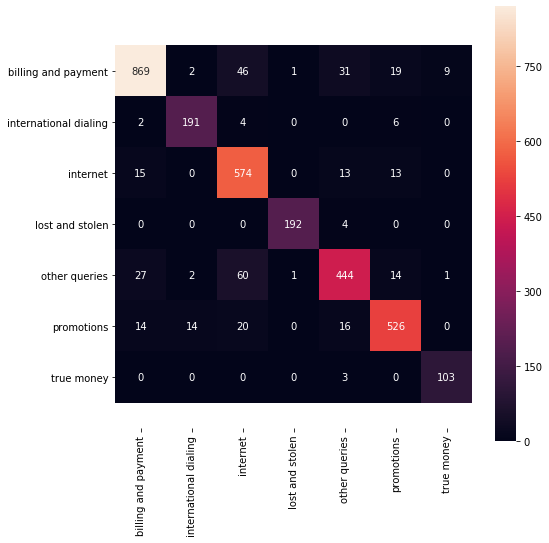

In [30]:
labels = list(onehot_encoder.categories_[0])
print("labels", labels)


plt.figure(figsize = (8,8))
ax = plt.subplot(111, aspect = 'equal')

sns.heatmap(confusion_matrix(y_orig, predictions_orig),
            annot=True, cmap="rocket", fmt="d",
            xticklabels=labels,
            yticklabels=labels,
            square=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)